# Basic hidden Markov models

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from hmm_classes import MultinomialHMM, GaussianHMM

### The unfair casino problem


#### Filtering

In [ ]:
diceA = np.array([[0.95, 0.05], [0.05, 0.95]])
diceB = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
                  [1/2, 1/10, 1/10, 1/10, 1/10, 1/10]])
diceπ = np.array([1., 0.])
casino = MultinomialHMM(diceA, diceB, diceπ)
T_max = 300

In [ ]:
state, obs = casino.generate(T_max)

In [ ]:
filter_path = np.array([casino.filter(obs[:t]) for t in range(1, T_max)])[:,1]

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(range(T_max), state, '.', color = 'blue', label = 'True state')
plt.plot(range(1, T_max), filter_path, label = 'Estimated state (filtering)', color = 'orange')
plt.plot([t for t in range(T_max) if obs[t] == 0], [0.02 for t in range(T_max) if obs[t] == 0], '|', markersize=20, color = 'red', label = 'Observed 1s')
plt.legend()
plt.show()

#### Smoothing

In [ ]:
smooth_path = casino.smooth(obs)[1, :]

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(range(T_max), state, '.', color = 'blue', label = 'True state')
plt.plot(range(T_max), smooth_path, label = 'Estimated state (smoothing)', color = 'orange')
plt.plot([t for t in range(T_max) if obs[t] == 0], [0.02 for t in range(T_max) if obs[t] == 0], '|', markersize=20, color = 'red', label = 'Observed 1s')
plt.legend()
plt.show()

#### Fitting

Here, we test the Baum-Welch algorithm for inferring model parameters, and see if it can recover the properties of the unfair casino model well enough to perform accurate filtering and smoothing on future data.

In [34]:
diceA = np.array([[0.95, 0.05], [0.05, 0.95]])
diceB = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
                  [1/2, 1/10, 1/10, 1/10, 1/10, 1/10]])
diceπ = np.array([1., 0.])
casino_true = MultinomialHMM(diceA, diceB, diceπ)
T_max = 1200

In [35]:
A = MultinomialHMM.init_matrix(3,3)
B = MultinomialHMM.init_matrix(3, 6)
π = MultinomialHMM.init_matrix(1,3).reshape(3)
casino_test = MultinomialHMM(A, B, π)

In [36]:
casino_test.B

array([[0.15740087, 0.17685095, 0.14665522, 0.15071561, 0.15954843,
        0.20882891],
       [0.14358079, 0.13415744, 0.17579504, 0.19419858, 0.1632302 ,
        0.18903795],
       [0.17992232, 0.17817037, 0.1835866 , 0.17263625, 0.14742261,
        0.13826185]])

In [38]:
casino_test.π

array([0.29663658, 0.39256056, 0.31080287])

In [39]:
state, obs = casino_true.generate(T_max)

In [24]:
obs[:60]

array([0, 2, 4, 4, 3, 3, 0, 1, 0, 1, 3, 0, 4, 3, 1, 3, 0, 4, 4, 2, 3, 4,
       5, 5, 0, 0, 3, 5, 4, 3, 3, 3, 4, 4, 0, 3, 5, 2, 1, 5, 4, 1, 1, 2,
       3, 4, 4, 5, 0, 0, 0, 5, 0, 0, 0, 0, 3, 0, 0, 1])

In [40]:
casino_test.fit(obs, max_iter=1000, verbose = True)

Initial log-probability: -2164.014651824275
Step 999;    delta log-probability: 0.001148
Maximum iterations reached.
Final log-probability: -2023.6511365815436


In [41]:
np.round(casino_test.B, 3)

array([[0.196, 0.149, 0.143, 0.155, 0.2  , 0.157],
       [0.508, 0.066, 0.129, 0.107, 0.133, 0.057],
       [0.065, 0.444, 0.   , 0.144, 0.   , 0.347]])

In [42]:
np.round(casino_test.A, 3)

array([[0.957, 0.043, 0.   ],
       [0.016, 0.921, 0.063],
       [0.144, 0.208, 0.647]])

In [32]:
casino_test.π

array([3.08557869e-27, 1.00000000e+00])

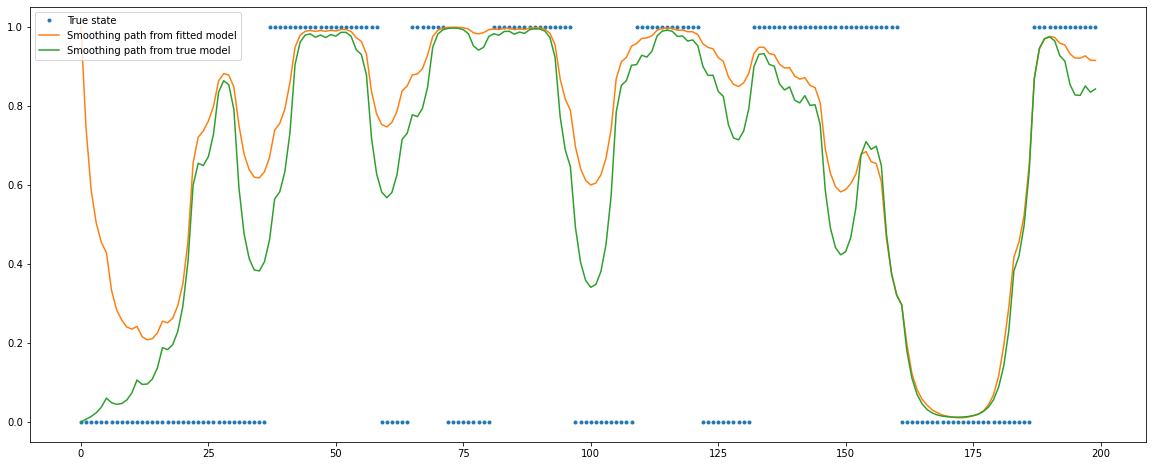

In [33]:
new_states, new_obs = casino_true.generate(200)
prediction = casino_test.smooth(new_obs)[1, :]
true_prediction = casino_true.smooth(new_obs)[1, :]
plt.figure(figsize=(20, 8))
plt.plot(range(200), new_states, '.', label = 'True state')
plt.plot(range(200), prediction, label = 'Smoothing path from fitted model')
plt.plot(range(200), true_prediction, label = 'Smoothing path from true model')
plt.legend()
plt.show()

## Using our HMM to analyze patterns in text

In [2]:
chars = ' abcdefghijklmnopqrstuvwxyz'
def sample_to_int(string):
    return np.array([chars.find(ch) for ch in string])

In [3]:
sample_to_int(chars)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [4]:
with open('dune_cleaned.txt') as fp:
    dune = fp.read()
    dune_raw = [ch for ch in dune.lower() if ch in chars]
    dune = sample_to_int(dune_raw)
len(dune)
max(dune)

26

In [5]:
''.join(dune_raw)[:500]

'dune frank herbert copyright  book  dune       a beginning is the time for taking the most delicate care that the balances are correct this every sister of the bene gesserit knows to begin your study of the life of muaddib then take care that you first place him in his time born in the th year of the padishah emperor shaddam iv and take the most special care that you locate muaddib in his place the planet arrakis do not be deceived by the fact that he was born on caladan and lived his first fift'

#### 2 states

In [19]:
A = MultinomialHMM.init_matrix(2,2)
B = MultinomialHMM.init_matrix(2,27)
π = MultinomialHMM.init_matrix(1,2).reshape(2)
dune_model = MultinomialHMM(A, B, π)

In [20]:
dune_model.fit(dune[1000:2000], max_iter=500, verbose = True)

Initial log-probability: -3272.9796746392194
Step 499;     delta log-probability: 5.1e-05
Maximum iterations reached.
Final log-probability: -2679.742545358353


In [22]:
dune_model.A

array([[0.21219852, 0.78780148],
       [0.72706856, 0.27293144]])

In [21]:
pd.DataFrame(data={'letter':list(chars),
                   'state1':np.round(dune_model.B[0,:], 3),
                   'state2':np.round(dune_model.B[1,:], 3)})

,letter,state1,state2
0,,0.022,0.354
1,a,0.000,0.138
2,b,0.023,0.000
3,c,0.020,0.003
4,d,0.098,0.000
5,e,0.000,0.227
6,f,0.029,0.000
7,g,0.024,0.003
8,h,0.113,0.000
9,i,0.000,0.085


#### 3 states

In [ ]:
A = MultinomialHMM.init_matrix(3,3)
B = MultinomialHMM.init_matrix(3,27)
π = MultinomialHMM.init_matrix(1,3).reshape(3)
dune_model = MultinomialHMM(A, B, π)

In [ ]:
dune_model.fit(dune[0:5000], max_iter=500, verbose = True)

In [ ]:
dune_model.A

In [ ]:
pd.DataFrame(data={'letter':list(chars),
                   'state1':np.round(dune_model.B[0,:], 3),
                   'state2':np.round(dune_model.B[1,:], 3),
                   'state3':np.round(dune_model.B[2,:], 3)})

## Gaussian emissions

Below we test a 2-state HMM. The emission distributions are chosen to overlap a fair amount so that the Markov process plays a strong role in estimating which state produced a given observation.

In [ ]:
# Set model parameters
A = np.array([[0.9, 0.1], [0.05, 0.95]])
means = [np.array([1.0, 2.0]), np.array([2.0, 1.0])]
covs = [np.eye(2), np.eye(2)]
π = np.array([0.5, 0.5])

In [ ]:
# Generate data
gmodel = GaussianHMM(A, means, covs, π)
states, obs = gmodel.generate(500)

In [ ]:
# What do the observed data look like?
plt.figure(figsize=(9, 9))
plt.plot(obs[:,0], obs[:,1], '.')
plt.show()

In [ ]:
# What do the observed data look like?
plt.figure(figsize=(9, 9))
plt.plot(obs[states==0,0], obs[states==0,1], '.', label = 'State 0')
plt.plot(obs[states==1,0], obs[states==1,1], '.', label = 'State 1')
plt.legend()
plt.show()

In [ ]:
smooth_path = gmodel.smooth(obs)

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(states)), states, '.', color = 'blue', label = 'True state')
plt.plot(range(len(states)), smooth_path[1, :], label = 'Estimated state (smoothing)', color = 'orange')
plt.legend()
plt.show()